In [46]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3060
Using device: cuda


In [47]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

root_dir = "D:/"
project_folder = "CSE_Research_Projects/CSE498R/"
os.chdir(root_dir+project_folder)

# Print the current directory
print("Current directory:", os.getcwd())

plt.ion()

# import warnings
# warnings.filterwarnings('ignore')

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if use_gpu:
    print("Using CUDA")
else:
  print("Not Using CUDA")

PyTorch Version:  2.4.0+cu118
Torchvision Version:  0.19.0+cpu
Current directory: D:\CSE_Research_Projects\CSE498R
Using CUDA


In [48]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "D:/CSE_Research_Projects/CSE498R/Dermnet_datasets"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, efficientNet]
# model_name = "hybrid_vgg_vit"
# model_name = "vgg"
model_name = "resnet50"

# Number of classes in the dataset
num_classes = 23

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Model will be train when true
train_model = True

# Make new split on dataset
dataset_split = False

In [49]:
# # !pip install split-folders
# if dataset_split:
#   import splitfolders
#   # !unzip '/content/drive/My Drive/Thesis/dataset'
#   splitfolders.ratio(data_dir+'/caltech-101', output=data_dir+'/transfer_learnng_dataset_spilited', seed=1337, ratio=(0.7,0.3))

In [50]:
# !pip install split-folders
if dataset_split:
  import splitfolders
  # !unzip '/content/drive/My Drive/Thesis/dataset'
  splitfolders.ratio(data_dir+'/train', output=data_dir+'/transfer_learnng_dataset_spilited', seed=1337, ratio=(0.7,0.3))

In [51]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [52]:
# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
#     since = time.time()

#     train_loss_history = []
#     train_acc_history = []
#     val_loss_history = []
#     val_acc_history = []

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     # Get model outputs and calculate loss
#                     # Special case for inception because in training it has an auxiliary output. In train
#                     #   mode we calculate the loss by summing the final output and the auxiliary output
#                     #   but in testing we only consider the final output.
#                     if is_inception and phase == 'train':
#                         # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
#                         outputs, aux_outputs = model(inputs)
#                         loss1 = criterion(outputs, labels)
#                         loss2 = criterion(aux_outputs, labels)
#                         loss = loss1 + 0.4*loss2
#                     else:
#                         outputs = model(inputs)
#                         loss = criterion(outputs, labels)

#                     _, preds = torch.max(outputs, 1)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_loss_history.append(epoch_loss)
#                 val_acc_history.append(epoch_acc)
#             if phase == 'train':
#                 train_loss_history.append(epoch_loss)
#                 train_acc_history.append(epoch_acc)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [53]:
import time
import copy
import torch
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training
import warnings
import os
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from tqdm import tqdm  # For better progress display during training

# Suppress FutureWarning messages
warnings.filterwarnings("ignore", category=FutureWarning)

def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25, is_inception=False):
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize GradScaler for mixed precision training
    scaler = GradScaler()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for displaying training progress
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch}/{num_epochs - 1}"):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass (with mixed precision for faster computation)
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast(enabled=phase == 'train'):  # Enable autocast only for training
                        if is_inception and phase == 'train':
                            outputs, aux_outputs = model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4 * loss2
                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()  # Scale loss for mixed precision
                        scaler.step(optimizer)  # Apply scaled gradients
                        scaler.update()  # Update scaler for the next iteration

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model if it has improved in validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                
                # Step the learning rate scheduler if it's not ReduceLROnPlateau
                if scheduler and not isinstance(scheduler, ReduceLROnPlateau):
                    scheduler.step()

            # For ReduceLROnPlateau, step after validation phase with validation loss
            if phase == 'val' and isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [54]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [55]:
import torch.nn as nn
from transformers import BeitForImageClassification, BeitFeatureExtractor

class HybridModel(nn.Module):
    def __init__(self, num_classes, use_pretrained=True, feature_extract=True):
        super(HybridModel, self).__init__()
        
        # VGG19
        self.vgg = models.vgg19_bn(pretrained=use_pretrained)
        self.set_parameter_requires_grad(self.vgg, feature_extract)
        num_ftrs_vgg = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(num_ftrs_vgg, num_classes)

        # Vision Transformer
        self.vit = models.vit_b_16(pretrained=use_pretrained)
        self.set_parameter_requires_grad(self.vit, feature_extract)
        num_ftrs_vit = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(num_ftrs_vit, num_classes)

        # Combined classifier
        self.classifier = nn.Linear(num_classes * 2, num_classes)  # Output from both models

    def set_parameter_requires_grad(self, model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False

    def forward(self, x):
        # Forward pass through VGG19
        vgg_out = self.vgg(x)

        # Forward pass through ViT
        vit_out = self.vit(x)

        # Concatenate outputs from both models
        combined_out = torch.cat((vgg_out, vit_out), dim=1)

        # Classifier
        output = self.classifier(combined_out)
        return output
    

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "efficientNet":
        """ EfficientNet-B0 """
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)  # Load EfficientNet-B0 model
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features  # Get input features of the last layer
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)  # Replace the classifier layer
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG19_bn """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "hybrid_vgg_vit":
        """ Hybrid model of VGG19 and ViT """
        model_ft = HybridModel(num_classes, use_pretrained, feature_extract)
        input_size = 224

    elif model_name == "resnet50":
        """ ResNet50 """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

## Starting The Training Of EfficientNet Model

In [71]:
if train_model:
    # [efficientNet, alexnet, squeezenet, beit]
    model_name = "efficientNet"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(p=0.5),                # Horizontal flip with 50% probability
        transforms.RandomRotation(degrees=15),                 # Rotate randomly by -15 to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                               saturation=0.2, hue=0.1),       # Randomly change brightness, contrast, etc.
        transforms.RandomGrayscale(p=0.1),                     # Convert to grayscale with 10% probability
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    image_datasets = {x: datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/' + x, data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft_efficientNet, train_loss_history_efficientNet, train_acc_history_efficientNet, val_loss_history_efficientNet, val_acc_history_efficientNet = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = root_dir + project_folder  + 'models/' + model_name
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_efficientNet.state_dict(), os.path.join(path,'model_ft_efficientNet.pth'))
    path =root_dir + project_folder  + 'models/' + model_name + '/analysis'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_efficientNet), os.path.join(path,'train_loss_history_efficientNet.pth'))
    torch.save(train_acc_history_efficientNet, os.path.join(path,'train_acc_history_efficientNet.pth'))
    torch.save(torch.tensor(val_loss_history_efficientNet), os.path.join(path,'val_loss_history_efficientNet.pth'))
    torch.save(val_acc_history_efficientNet, os.path.join(path,'val_acc_history_efficientNet.pth'))

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

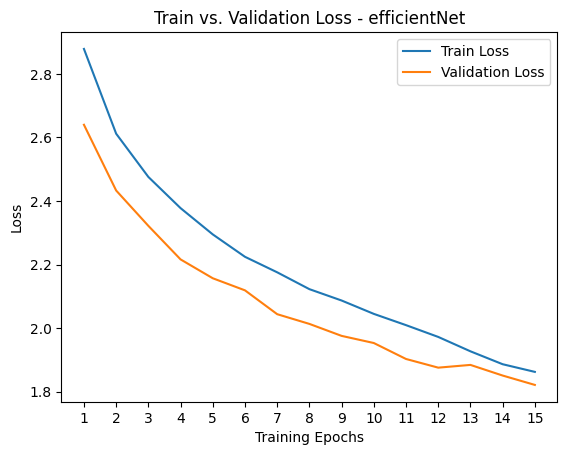

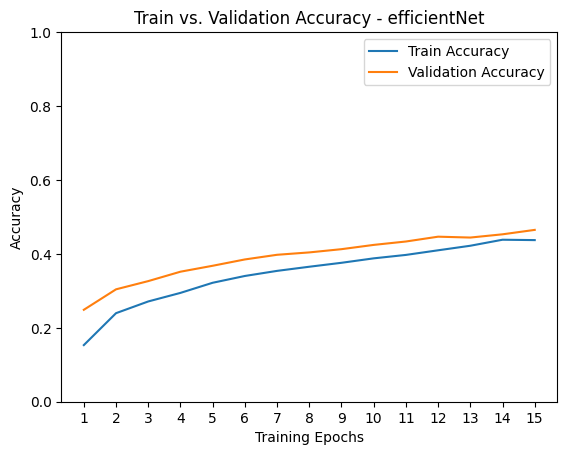

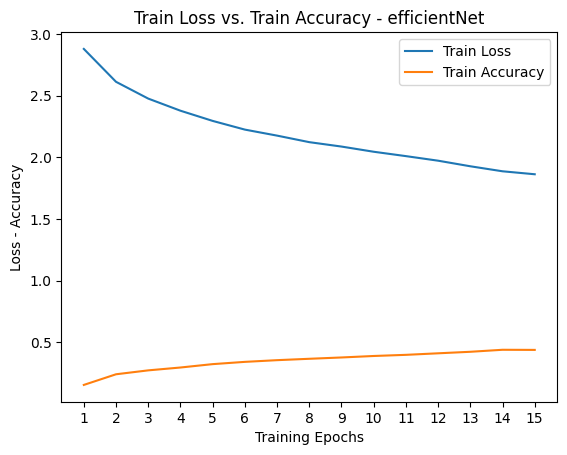

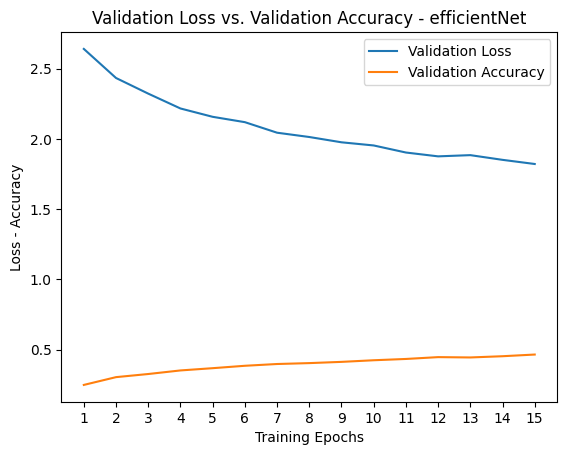

In [72]:
if train_model:
    # train_loss_history_efficientNet, train_acc_history_efficientNet, val_loss_history_efficientNet, val_acc_history_efficientNet
    t_loss_efficientNet = [np.array(h) for h in train_loss_history_efficientNet]
    v_loss_efficientNet = [np.array(h) for h in val_loss_history_efficientNet]
    plt.title("Train vs. Validation Loss - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_efficientNet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_efficientNet,label="Validation Loss")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_efficientNet = [h.cpu().numpy() for h in train_acc_history_efficientNet]
    v_acc_efficientNet = [h.cpu().numpy() for h in val_acc_history_efficientNet]
    plt.title("Train vs. Validation Accuracy - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_efficientNet,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_efficientNet,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_efficientNet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_efficientNet,label="Train Accuracy")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_efficientNet,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_efficientNet,label="Validation Accuracy")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

4002
Classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Test accurate: 1865/4002

Test acc: 46.6017

                               

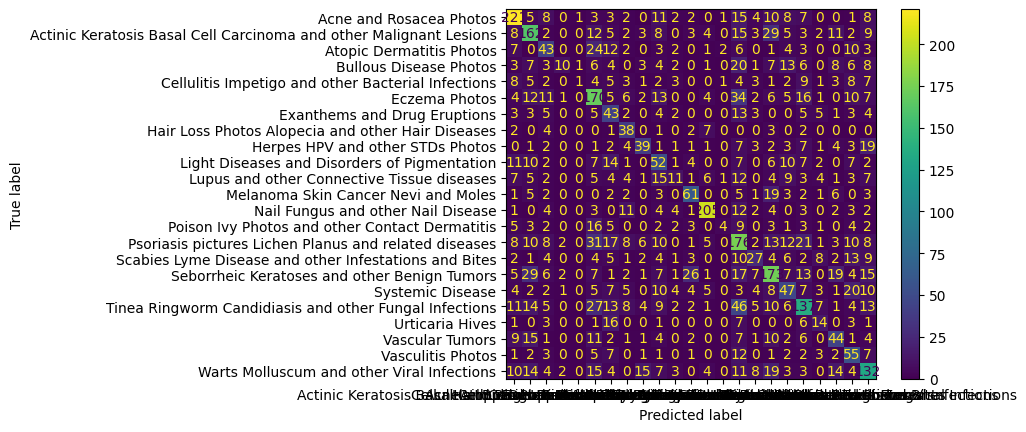

In [73]:
data_transforms = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

testset = datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/test', transform=data_transforms)
print(len(testset))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

class_names = testset.classes
print("Classes:", class_names)

#Evaluating test dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model_ft_efficientNet.eval()
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model_ft_efficientNet(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        # print(f'Batch Test accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Test accurate: {correct}/{total}\n')
    print(f'Test acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

## Starting The Training Of Vgg_bn19 Model



In [ ]:
# if train_model:
#     # [efficienNet, alexnet, squeezenet, vgg, beit]
#     model_name = "vgg"
#     feature_extract = True

#     # Initialize the model for this run
#     model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

#     # Print the model we just instantiated
#     print(model_ft)

#     # Data augmentation and normalization for training
#     # Just normalization for validation
#     data_transforms = {
#         'train': transforms.Compose([
#             transforms.RandomResizedCrop(input_size),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         ]),
#         'val': transforms.Compose([
#             transforms.Resize(input_size),
#             transforms.CenterCrop(input_size),
#             transforms.ToTensor(),
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         ]),
#     }

#     print("Initializing Datasets and Dataloaders...")

#     # Create training and validation datasets
#     # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#     image_datasets = {x: datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/' + x, data_transforms[x]) for x in ['train', 'val']}
#     # Create training and validation dataloaders
#     dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

#     # Detect if we have a GPU available
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#     # Send the model to GPU
#     model_ft = model_ft.to(device)
#     summary(model_ft, (3, input_size, input_size))
#     # Gather the parameters to be optimized/updated in this run. If we are
#     #  finetuning we will be updating all parameters. However, if we are
#     #  doing feature extract method, we will only update the parameters
#     #  that we have just initialized, i.e. the parameters with requires_grad
#     #  is True.
#     params_to_update = model_ft.parameters()
#     print("Params to learn:")
#     if feature_extract:
#         params_to_update = []
#         for name,param in model_ft.named_parameters():
#             if param.requires_grad == True:
#                 params_to_update.append(param)
#                 print("\t",name)
#     else:
#         for name,param in model_ft.named_parameters():
#             if param.requires_grad == True:
#                 print("\t",name)

#     # Observe that all parameters are being optimized
#     optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

#     # Setup the loss fxn
#     criterion = nn.CrossEntropyLoss()
#     # Train and evaluate
#     model_ft_vgg, train_loss_history_vgg, train_acc_history_vgg, val_loss_history_vgg, val_acc_history_vgg = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
#     path = root_dir + project_folder  + 'models/' + model_name
#     os.makedirs(path, exist_ok = True)
#     torch.save(model_ft_vgg.state_dict(), os.path.join(path,'model_ft_vgg.pth'))
#     path =root_dir + project_folder  + 'models/' + model_name + '/analysis'
#     os.makedirs(path, exist_ok = True)
#     torch.save(torch.tensor(train_loss_history_vgg), os.path.join(path,'train_loss_history_vgg.pth'))
#     torch.save(train_acc_history_vgg, os.path.join(path,'train_acc_history_vgg.pth'))
#     torch.save(torch.tensor(val_loss_history_vgg), os.path.join(path,'val_loss_history_vgg.pth'))
#     torch.save(val_acc_history_vgg, os.path.join(path,'val_acc_history_vgg.pth'))

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

TypeError: 'bool' object is not callable

In [43]:
if train_model:
    # [efficienNet, alexnet, squeezenet, vgg, beit]
    model_name = "vgg"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    image_datasets = {x: datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/' + x, data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft_vgg, train_loss_history_vgg, train_acc_history_vgg, val_loss_history_vgg, val_acc_history_vgg = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = root_dir + project_folder  + 'models/' + model_name
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_vgg.state_dict(), os.path.join(path,'model_ft_vgg.pth'))
    path =root_dir + project_folder  + 'models/' + model_name + '/analysis'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_vgg), os.path.join(path,'train_loss_history_vgg.pth'))
    torch.save(train_acc_history_vgg, os.path.join(path,'train_acc_history_vgg.pth'))
    torch.save(torch.tensor(val_loss_history_vgg), os.path.join(path,'val_loss_history_vgg.pth'))
    torch.save(val_acc_history_vgg, os.path.join(path,'val_acc_history_vgg.pth'))

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Train Epoch 0/19: 100%|██████████| 341/341 [01:42<00:00,  3.34it/s]


train Loss: 2.5887 Acc: 0.2350


Val Epoch 0/19: 100%|██████████| 147/147 [00:28<00:00,  5.21it/s]


val Loss: 2.1951 Acc: 0.3522

Epoch 1/19
----------


Train Epoch 1/19: 100%|██████████| 341/341 [01:41<00:00,  3.36it/s]


train Loss: 2.2331 Acc: 0.3326


Val Epoch 1/19: 100%|██████████| 147/147 [00:27<00:00,  5.32it/s]


val Loss: 2.0395 Acc: 0.4033

Epoch 2/19
----------


Train Epoch 2/19: 100%|██████████| 341/341 [01:39<00:00,  3.42it/s]


train Loss: 2.0738 Acc: 0.3825


Val Epoch 2/19: 100%|██████████| 147/147 [00:27<00:00,  5.31it/s]


val Loss: 1.9009 Acc: 0.4408

Epoch 3/19
----------


Train Epoch 3/19: 100%|██████████| 341/341 [01:39<00:00,  3.42it/s]


train Loss: 1.9449 Acc: 0.4111


Val Epoch 3/19: 100%|██████████| 147/147 [00:27<00:00,  5.33it/s]


val Loss: 1.8266 Acc: 0.4600

Epoch 4/19
----------


Train Epoch 4/19: 100%|██████████| 341/341 [01:39<00:00,  3.42it/s]


train Loss: 1.8429 Acc: 0.4445


Val Epoch 4/19: 100%|██████████| 147/147 [00:27<00:00,  5.33it/s]


val Loss: 1.7859 Acc: 0.4773

Epoch 5/19
----------


Train Epoch 5/19: 100%|██████████| 341/341 [01:39<00:00,  3.42it/s]


train Loss: 1.7494 Acc: 0.4688


Val Epoch 5/19: 100%|██████████| 147/147 [00:27<00:00,  5.33it/s]


val Loss: 1.7651 Acc: 0.4778

Epoch 6/19
----------


Train Epoch 6/19: 100%|██████████| 341/341 [01:39<00:00,  3.42it/s]


train Loss: 1.6815 Acc: 0.4899


Val Epoch 6/19: 100%|██████████| 147/147 [00:27<00:00,  5.35it/s]


val Loss: 1.7282 Acc: 0.4899

Epoch 7/19
----------


Train Epoch 7/19: 100%|██████████| 341/341 [01:41<00:00,  3.36it/s]


train Loss: 1.6022 Acc: 0.5164


Val Epoch 7/19: 100%|██████████| 147/147 [00:28<00:00,  5.20it/s]


val Loss: 1.6681 Acc: 0.5111

Epoch 8/19
----------


Train Epoch 8/19: 100%|██████████| 341/341 [01:42<00:00,  3.33it/s]


train Loss: 1.5286 Acc: 0.5373


Val Epoch 8/19: 100%|██████████| 147/147 [00:28<00:00,  5.21it/s]


val Loss: 1.7086 Acc: 0.5062

Epoch 9/19
----------


Train Epoch 9/19: 100%|██████████| 341/341 [01:42<00:00,  3.33it/s]


train Loss: 1.4690 Acc: 0.5523


Val Epoch 9/19: 100%|██████████| 147/147 [00:28<00:00,  5.20it/s]


val Loss: 1.7030 Acc: 0.5051

Epoch 10/19
----------


Train Epoch 10/19: 100%|██████████| 341/341 [01:42<00:00,  3.33it/s]


train Loss: 1.4023 Acc: 0.5669


Val Epoch 10/19: 100%|██████████| 147/147 [00:28<00:00,  5.20it/s]


val Loss: 1.6001 Acc: 0.5428

Epoch 11/19
----------


Train Epoch 11/19: 100%|██████████| 341/341 [01:42<00:00,  3.33it/s]


train Loss: 1.3654 Acc: 0.5806


Val Epoch 11/19: 100%|██████████| 147/147 [00:28<00:00,  5.20it/s]


val Loss: 1.6060 Acc: 0.5408

Epoch 12/19
----------


Train Epoch 12/19: 100%|██████████| 341/341 [01:42<00:00,  3.33it/s]


train Loss: 1.3162 Acc: 0.5875


Val Epoch 12/19: 100%|██████████| 147/147 [00:28<00:00,  5.21it/s]


val Loss: 1.6452 Acc: 0.5396

Epoch 13/19
----------


Train Epoch 13/19: 100%|██████████| 341/341 [01:42<00:00,  3.32it/s]


train Loss: 1.2575 Acc: 0.6107


Val Epoch 13/19: 100%|██████████| 147/147 [00:28<00:00,  5.20it/s]


val Loss: 1.5772 Acc: 0.5580

Epoch 14/19
----------


Train Epoch 14/19: 100%|██████████| 341/341 [01:42<00:00,  3.32it/s]


train Loss: 1.2125 Acc: 0.6271


Val Epoch 14/19: 100%|██████████| 147/147 [00:28<00:00,  5.15it/s]


val Loss: 1.6002 Acc: 0.5582

Epoch 15/19
----------


Train Epoch 15/19: 100%|██████████| 341/341 [01:42<00:00,  3.32it/s]


train Loss: 1.1923 Acc: 0.6328


Val Epoch 15/19: 100%|██████████| 147/147 [00:28<00:00,  5.17it/s]


val Loss: 1.6182 Acc: 0.5530

Epoch 16/19
----------


Train Epoch 16/19: 100%|██████████| 341/341 [01:42<00:00,  3.32it/s]


train Loss: 1.1334 Acc: 0.6484


Val Epoch 16/19: 100%|██████████| 147/147 [00:30<00:00,  4.90it/s]


val Loss: 1.6639 Acc: 0.5567

Epoch 17/19
----------


Train Epoch 17/19: 100%|██████████| 341/341 [01:42<00:00,  3.33it/s]


train Loss: 1.0877 Acc: 0.6602


Val Epoch 17/19: 100%|██████████| 147/147 [00:28<00:00,  5.19it/s]


val Loss: 1.6234 Acc: 0.5588

Epoch 18/19
----------


Train Epoch 18/19: 100%|██████████| 341/341 [01:42<00:00,  3.33it/s]


train Loss: 1.0564 Acc: 0.6722


Val Epoch 18/19: 100%|██████████| 147/147 [00:28<00:00,  5.25it/s]


val Loss: 1.7084 Acc: 0.5552

Epoch 19/19
----------


Train Epoch 19/19: 100%|██████████| 341/341 [01:41<00:00,  3.36it/s]


train Loss: 1.0208 Acc: 0.6775


Val Epoch 19/19: 100%|██████████| 147/147 [00:28<00:00,  5.18it/s]


val Loss: 1.6298 Acc: 0.5691

Training complete in 43m 16s
Best val Acc: 0.569076


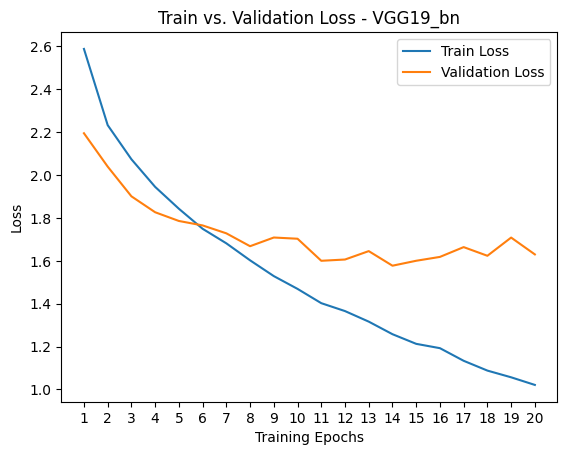

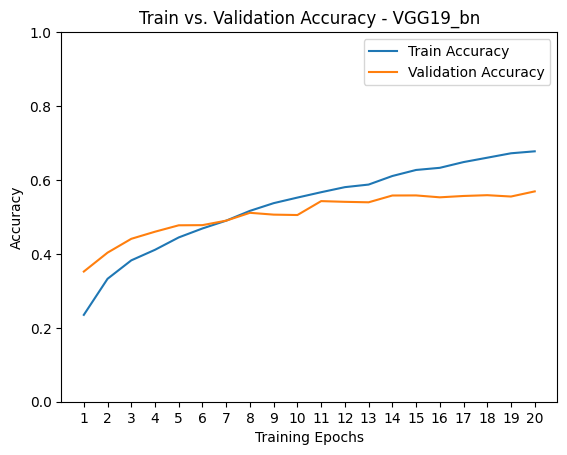

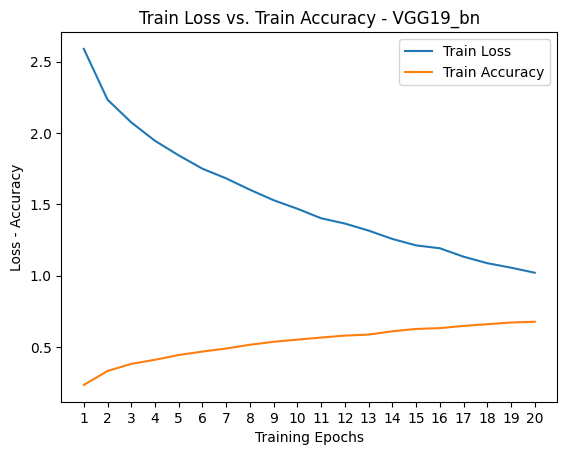

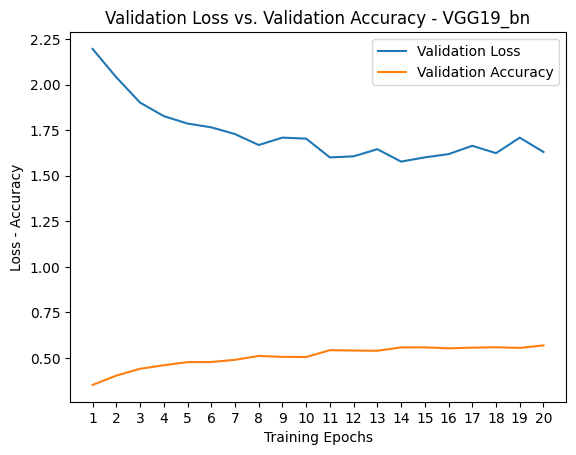

In [44]:
if train_model:
    # train_loss_history_vgg, train_acc_history_vgg, val_loss_history_vgg, val_acc_history_vgg
    t_loss_vgg = [np.array(h) for h in train_loss_history_vgg]
    v_loss_vgg = [np.array(h) for h in val_loss_history_vgg]
    plt.title("Train vs. Validation Loss - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_vgg,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_vgg,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_vgg = [h.cpu().numpy() for h in train_acc_history_vgg]
    v_acc_vgg = [h.cpu().numpy() for h in val_acc_history_vgg]
    plt.title("Train vs. Validation Accuracy - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_vgg,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_vgg,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_vgg,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_vgg,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_vgg,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_vgg,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

4002
Classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Test accurate: 2320/4002

Test acc: 57.9710

                               

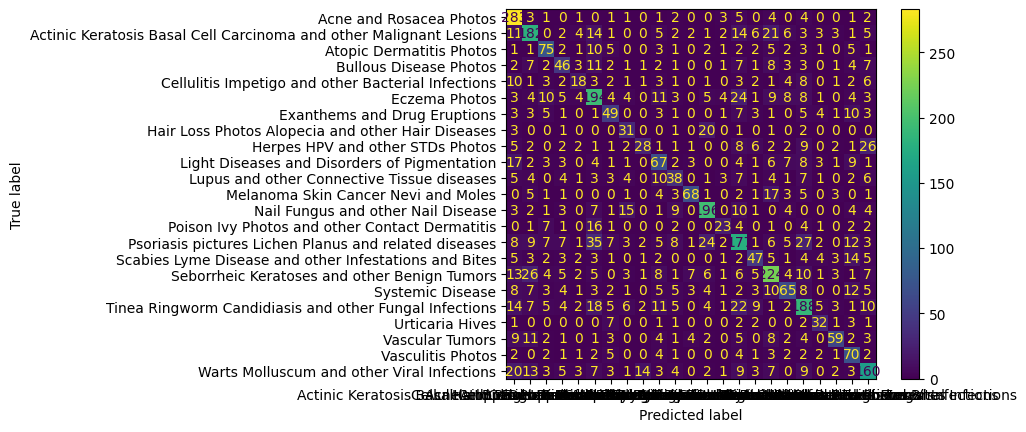

In [45]:
# Initializing transformers for test dataset
data_transforms = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

testset = datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/test', transform=data_transforms)
print(len(testset))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Defining class names
class_names = testset.classes
print("Classes:", class_names)


#Evaluating test dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model_ft_vgg.eval()
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model_ft_vgg(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        # print(f'Batch Test accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Test accurate: {correct}/{total}\n')
    print(f'Test acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

## Starting The Training Of Resnet50 Model

In [56]:
if train_model:
    # [efficienNet, alexnet, squeezenet, resnet50, beit]
    model_name = "resnet50"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    image_datasets = {x: datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/' + x, data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft_resnet50, train_loss_history_resnet50, train_acc_history_resnet50, val_loss_history_resnet50, val_acc_history_resnet50 = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = root_dir + project_folder  + 'models/' + model_name
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_resnet50.state_dict(), os.path.join(path,'model_ft_resnet50.pth'))
    path =root_dir + project_folder  + 'models/' + model_name + '/analysis'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_resnet50), os.path.join(path,'train_loss_history_resnet50.pth'))
    torch.save(train_acc_history_resnet50, os.path.join(path,'train_acc_history_resnet50.pth'))
    torch.save(torch.tensor(val_loss_history_resnet50), os.path.join(path,'val_loss_history_resnet50.pth'))
    torch.save(val_acc_history_resnet50, os.path.join(path,'val_acc_history_resnet50.pth'))

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:33<00:00, 3.06MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Train Epoch 0/19: 100%|██████████| 341/341 [00:40<00:00,  8.36it/s]


train Loss: 2.5873 Acc: 0.2422


Val Epoch 0/19: 100%|██████████| 147/147 [00:15<00:00,  9.52it/s]


val Loss: 2.2232 Acc: 0.3417

Epoch 1/19
----------


Train Epoch 1/19: 100%|██████████| 341/341 [00:40<00:00,  8.48it/s]


train Loss: 2.1809 Acc: 0.3474


Val Epoch 1/19: 100%|██████████| 147/147 [00:15<00:00,  9.67it/s]


val Loss: 2.0614 Acc: 0.3959

Epoch 2/19
----------


Train Epoch 2/19: 100%|██████████| 341/341 [00:40<00:00,  8.46it/s]


train Loss: 1.9772 Acc: 0.4134


Val Epoch 2/19: 100%|██████████| 147/147 [00:15<00:00,  9.57it/s]


val Loss: 1.8725 Acc: 0.4508

Epoch 3/19
----------


Train Epoch 3/19: 100%|██████████| 341/341 [00:40<00:00,  8.39it/s]


train Loss: 1.8295 Acc: 0.4523


Val Epoch 3/19: 100%|██████████| 147/147 [00:15<00:00,  9.46it/s]


val Loss: 1.8114 Acc: 0.4658

Epoch 4/19
----------


Train Epoch 4/19: 100%|██████████| 341/341 [00:40<00:00,  8.40it/s]


train Loss: 1.6900 Acc: 0.4878


Val Epoch 4/19: 100%|██████████| 147/147 [00:15<00:00,  9.59it/s]


val Loss: 1.7309 Acc: 0.4962

Epoch 5/19
----------


Train Epoch 5/19: 100%|██████████| 341/341 [00:40<00:00,  8.38it/s]


train Loss: 1.5760 Acc: 0.5233


Val Epoch 5/19: 100%|██████████| 147/147 [00:15<00:00,  9.49it/s]


val Loss: 1.7503 Acc: 0.4932

Epoch 6/19
----------


Train Epoch 6/19: 100%|██████████| 341/341 [00:40<00:00,  8.39it/s]


train Loss: 1.4711 Acc: 0.5522


Val Epoch 6/19: 100%|██████████| 147/147 [00:15<00:00,  9.48it/s]


val Loss: 1.6771 Acc: 0.5214

Epoch 7/19
----------


Train Epoch 7/19: 100%|██████████| 341/341 [00:40<00:00,  8.40it/s]


train Loss: 1.3619 Acc: 0.5841


Val Epoch 7/19: 100%|██████████| 147/147 [00:15<00:00,  9.52it/s]


val Loss: 1.6628 Acc: 0.5257

Epoch 8/19
----------


Train Epoch 8/19: 100%|██████████| 341/341 [00:40<00:00,  8.37it/s]


train Loss: 1.2797 Acc: 0.6090


Val Epoch 8/19: 100%|██████████| 147/147 [00:15<00:00,  9.56it/s]


val Loss: 1.6423 Acc: 0.5304

Epoch 9/19
----------


Train Epoch 9/19: 100%|██████████| 341/341 [00:40<00:00,  8.37it/s]


train Loss: 1.2053 Acc: 0.6301


Val Epoch 9/19: 100%|██████████| 147/147 [00:15<00:00,  9.49it/s]


val Loss: 1.6594 Acc: 0.5428

Epoch 10/19
----------


Train Epoch 10/19: 100%|██████████| 341/341 [00:40<00:00,  8.38it/s]


train Loss: 1.1315 Acc: 0.6516


Val Epoch 10/19: 100%|██████████| 147/147 [00:15<00:00,  9.41it/s]


val Loss: 1.6949 Acc: 0.5509

Epoch 11/19
----------


Train Epoch 11/19: 100%|██████████| 341/341 [00:40<00:00,  8.42it/s]


train Loss: 1.0553 Acc: 0.6711


Val Epoch 11/19: 100%|██████████| 147/147 [00:15<00:00,  9.48it/s]


val Loss: 1.7059 Acc: 0.5485

Epoch 12/19
----------


Train Epoch 12/19: 100%|██████████| 341/341 [00:40<00:00,  8.37it/s]


train Loss: 1.0171 Acc: 0.6842


Val Epoch 12/19: 100%|██████████| 147/147 [00:15<00:00,  9.49it/s]


val Loss: 1.7020 Acc: 0.5618

Epoch 13/19
----------


Train Epoch 13/19: 100%|██████████| 341/341 [00:40<00:00,  8.37it/s]


train Loss: 0.9394 Acc: 0.7043


Val Epoch 13/19: 100%|██████████| 147/147 [00:15<00:00,  9.45it/s]


val Loss: 1.7034 Acc: 0.5586

Epoch 14/19
----------


Train Epoch 14/19: 100%|██████████| 341/341 [00:40<00:00,  8.36it/s]


train Loss: 0.8855 Acc: 0.7234


Val Epoch 14/19: 100%|██████████| 147/147 [00:15<00:00,  9.46it/s]


val Loss: 1.7599 Acc: 0.5654

Epoch 15/19
----------


Train Epoch 15/19: 100%|██████████| 341/341 [00:40<00:00,  8.36it/s]


train Loss: 0.8507 Acc: 0.7365


Val Epoch 15/19: 100%|██████████| 147/147 [00:15<00:00,  9.57it/s]


val Loss: 1.7858 Acc: 0.5577

Epoch 16/19
----------


Train Epoch 16/19: 100%|██████████| 341/341 [00:40<00:00,  8.40it/s]


train Loss: 0.8260 Acc: 0.7402


Val Epoch 16/19: 100%|██████████| 147/147 [00:15<00:00,  9.47it/s]


val Loss: 1.6820 Acc: 0.5896

Epoch 17/19
----------


Train Epoch 17/19: 100%|██████████| 341/341 [00:40<00:00,  8.39it/s]


train Loss: 0.7761 Acc: 0.7548


Val Epoch 17/19: 100%|██████████| 147/147 [00:15<00:00,  9.39it/s]


val Loss: 1.8222 Acc: 0.5569

Epoch 18/19
----------


Train Epoch 18/19: 100%|██████████| 341/341 [00:40<00:00,  8.41it/s]


train Loss: 0.7277 Acc: 0.7665


Val Epoch 18/19: 100%|██████████| 147/147 [00:15<00:00,  9.45it/s]


val Loss: 1.7491 Acc: 0.5740

Epoch 19/19
----------


Train Epoch 19/19: 100%|██████████| 341/341 [00:40<00:00,  8.39it/s]


train Loss: 0.7029 Acc: 0.7766


Val Epoch 19/19: 100%|██████████| 147/147 [00:15<00:00,  9.47it/s]

val Loss: 1.7694 Acc: 0.5798

Training complete in 18m 42s
Best val Acc: 0.589607


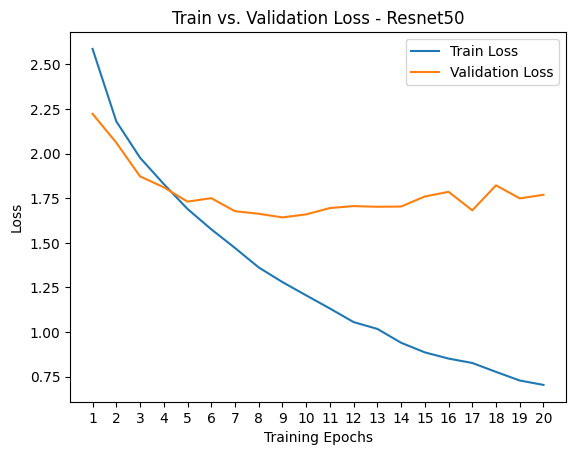

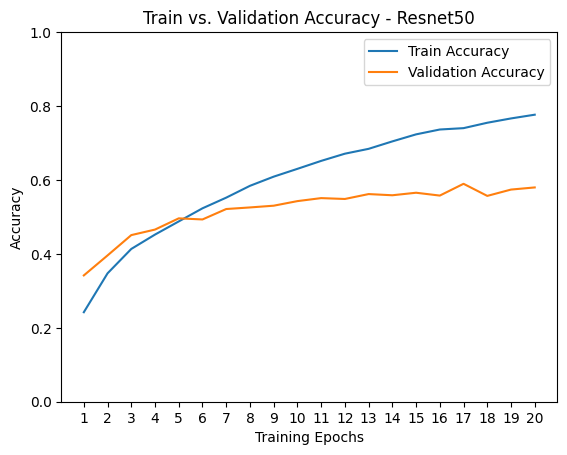

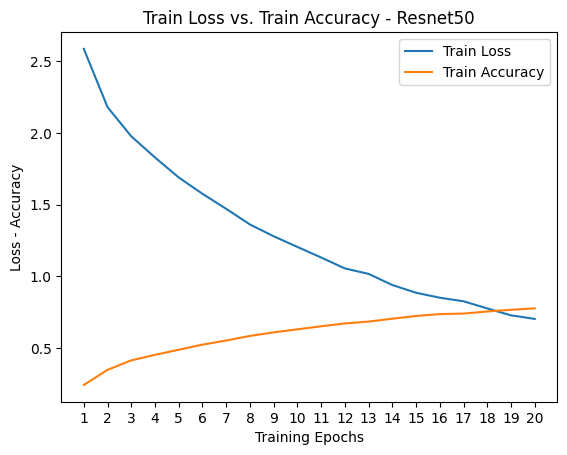

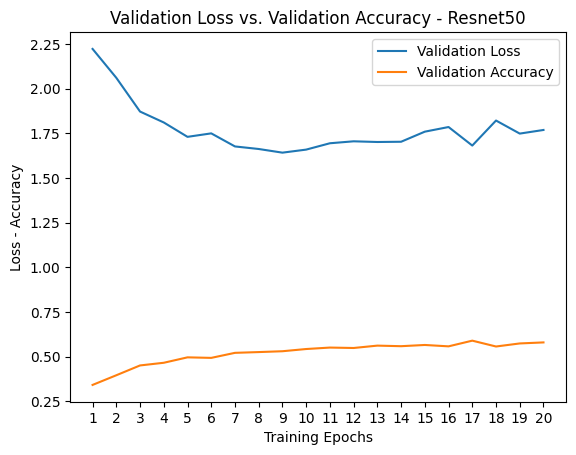

In [58]:
if train_model:
    # train_loss_history_resnet50, train_acc_history_resnet50, val_loss_history_resnet50, val_acc_history_resnet50
    t_loss_resnet50 = [np.array(h) for h in train_loss_history_resnet50]
    v_loss_resnet50 = [np.array(h) for h in val_loss_history_resnet50]
    plt.title("Train vs. Validation Loss - Resnet50")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_resnet50,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_resnet50,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_resnet50 = [h.cpu().numpy() for h in train_acc_history_resnet50]
    v_acc_resnet50 = [h.cpu().numpy() for h in val_acc_history_resnet50]
    plt.title("Train vs. Validation Accuracy - Resnet50")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_resnet50,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_resnet50,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - Resnet50")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_resnet50,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_resnet50,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - Resnet50")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_resnet50,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_resnet50,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(

4002
Classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Test accurate: 2343/4002

Test acc: 58.5457

                               

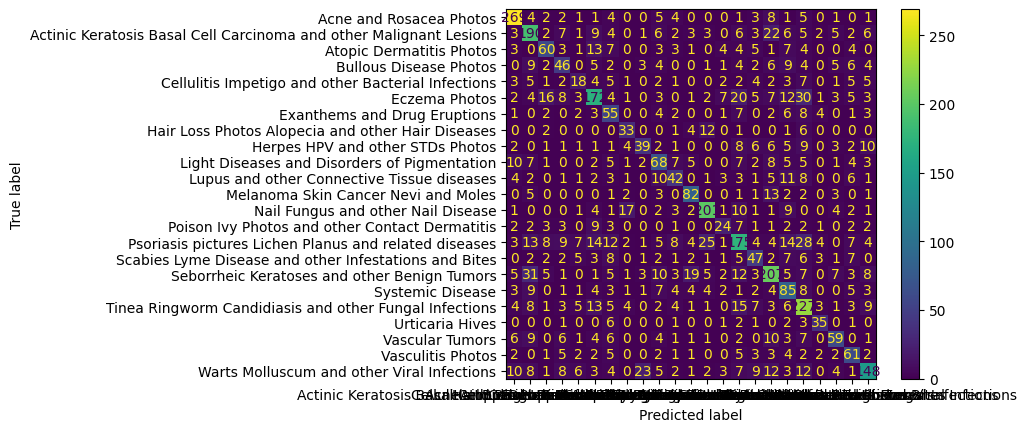

In [59]:
# Initializing transformers for test dataset
data_transforms = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

testset = datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/test', transform=data_transforms)
print(len(testset))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Defining class names
class_names = testset.classes
print("Classes:", class_names)


#Evaluating test dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model_ft_resnet50.eval()
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model_ft_resnet50(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        # print(f'Batch Test accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Test accurate: {correct}/{total}\n')
    print(f'Test acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()